In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import seaborn as sns
from datetime import datetime
import yfinance as yf
yf.pdr_override()

c:\Users\cptfr\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
tickers = ["PETR4.SA", 'VALE3.SA', 'ITUB4.SA', 'BBAS3.SA', 'BBDC3.SA']
# Baixando os dados dos tickers
carteira = yf.download(tickers, start="2002-01-01",end="2023-12-31")['Adj Close']
# Baixando os dados do índice Ibovespa
ibov = yf.download('^BVSP', start="2002-01-01", end="2023-12-31")['Adj Close']

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
carteira.ffill(inplace=True)
carteira.bfill(inplace=True)
carteira

,BBAS3.SA,BBDC3.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,
2002-01-01,0.263994,1.026872,1.617727,1.571674,1.896706
2002-01-02,0.268730,1.026872,1.691356,1.574748,1.860230
2002-01-03,0.272968,1.034691,1.672881,1.585502,1.889411
2002-01-04,0.266736,1.030782,1.645395,1.575669,1.929533
2002-01-07,0.260753,1.034691,1.627103,1.610083,1.929533
...,...,...,...,...,...
2023-12-21,26.554211,14.914569,31.443794,33.934216,73.674408
2023-12-22,26.627575,14.951639,31.942448,34.260597,73.119240
2023-12-26,26.872135,15.011247,32.268490,34.810783,73.377686


In [5]:
#https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial={02/01/2002}&dataFinal={29/12/2023}

In [6]:
# Caminho do arquivo JSON com os dados da taxa Selic
caminho_do_arquivo = r'C:\Users\cptfr\Desktop\TCC_B3_OPCOES\dadosselicdiario.json'

# Lendo o arquivo JSON e transformando em DataFrame para manipulação de dados
selic = pd.read_json(caminho_do_arquivo)

# Converte a coluna 'data' do formato string para datetime, facilitando manipulações de data
selic['data'] = pd.to_datetime(selic['data'], format='%d/%m/%Y')

# Renomeia a coluna 'data' para 'Date' para padronização em inglês
selic.rename(columns={'data':'Date'}, inplace=True)

# Define a coluna 'Date' como índice do DataFrame, otimizando buscas e filtragens por data
selic.set_index('Date', inplace=True)

# Cria um novo DataFrame chamado 'selic_valores' contendo apenas a coluna 'valor', agora renomeada para 'SELIC'
selic_valores = pd.DataFrame(selic['valor']).rename(columns={'valor':'SELIC'})
selic_valores.index = pd.to_datetime(selic_valores.index)
selic_valores

,SELIC
Date,
2002-01-02,0.069220
2002-01-03,0.069220
2002-01-04,0.069220
2002-01-07,0.069220
2002-01-08,0.069220
...,...
2023-12-22,0.043739
2023-12-26,0.043739
2023-12-27,0.043739


In [7]:
carteira = carteira.pct_change()
df_combinado_outer = selic_valores.join(carteira, how='outer')
df_combinado_outer

,SELIC,BBAS3.SA,BBDC3.SA,ITUB4.SA,PETR4.SA,VALE3.SA
Date,,,,,,
2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-02,0.069220,0.017941,0.000000,0.045514,0.001955,-0.019231
2002-01-03,0.069220,0.015770,0.007614,-0.010923,0.006829,0.015687
2002-01-04,0.069220,-0.022831,-0.003778,-0.016430,-0.006202,0.021235
2002-01-07,0.069220,-0.022430,0.003792,-0.011117,0.021841,0.000000
...,...,...,...,...,...,...
2023-12-22,0.043739,0.002763,0.002486,0.015859,0.009618,-0.007535
2023-12-26,0.043739,0.009184,0.003987,0.010207,0.016059,0.003535
2023-12-27,0.043739,-0.001456,0.007280,0.006835,0.000804,0.009653


In [8]:
def preencher_nans(df):
    # Preenche NaNs com o valor anterior (forward fill)
    df.ffill(inplace=True)
    # Para os casos onde o primeiro valor é NaN, preenche com o valor seguinte (backward fill)
    df.bfill(inplace=True)
    return df

In [9]:
carteiras_normalizadas = {}  # Dicionário para armazenar as carteiras de cada ano
valor_selic = 20000 
valor_acoes = 6000


In [10]:
for ano in range(2002, 2024):
    # Filtrar dados do ano atual e preencher NaNs
    carteira_ano = preencher_nans(df_combinado_outer[f'{ano}-01-01':f'{ano}-12-31'].copy())
    # Se for o primeiro ano, normalizar com base no primeiro valor
    carteira_normalizada = pd.DataFrame(index=carteira_ano.index,columns=['SELIC','BBAS3.SA','BBDC3.SA',
                                                                          'ITUB4.SA','PETR4.SA','VALE3.SA','SomaAcoes','Saldo'])
    if ano == 2002:
        carteira_normalizada['SELIC'].iloc[0] = valor_selic
        for coluna in carteira_ano.columns:
            if coluna == 'SELIC':
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i]/100)) + carteira_normalizada[coluna].iloc[i-1]
            else:
                carteira_normalizada[coluna].iloc[0] = valor_acoes
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i])) + carteira_normalizada[coluna].iloc[i-1]
        carteira_normalizada['SomaAcoes'] = carteira_normalizada.loc[:,['BBAS3.SA','BBDC3.SA','ITUB4.SA','PETR4.SA','VALE3.SA']].sum(axis=1)
        carteira_normalizada['Saldo'] = carteira_normalizada.loc[:,['SomaAcoes','SELIC']].sum(axis=1)
        saldo_final = carteira_normalizada.iloc[-1]['Saldo']
    else:
        carteira_normalizada['SELIC'].iloc[0] = saldo_final * 0.4
        for coluna in carteira_ano.columns:
            if coluna == 'SELIC':
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i]/100)) + carteira_normalizada[coluna].iloc[i-1]
            else:
                carteira_normalizada[coluna].iloc[0] = (saldo_final * 0.6)/5
                for i in range(1,len(carteira_ano)):
                    carteira_normalizada[coluna].iloc[i] = (carteira_normalizada[coluna].iloc[i-1] * (carteira_ano[coluna].iloc[i])) + carteira_normalizada[coluna].iloc[i-1]
        carteira_normalizada['SomaAcoes'] = carteira_normalizada.loc[:,['BBAS3.SA','BBDC3.SA','ITUB4.SA','PETR4.SA','VALE3.SA']].sum(axis=1)
        carteira_normalizada['Saldo'] = carteira_normalizada.loc[:,['SomaAcoes','SELIC']].sum(axis=1)
        saldo_final = carteira_normalizada.iloc[-1]['Saldo']
    carteiras_normalizadas[ano] = carteira_normalizada
print(carteiras_normalizadas)
carteira_total = pd.concat(carteiras_normalizadas.values())

{2002:                    SELIC     BBAS3.SA     BBDC3.SA     ITUB4.SA     PETR4.SA  \
Date                                                                           
2002-01-01         20000         6000         6000         6000         6000   
2002-01-02     20013.844  6107.646387       6000.0  6273.082288  6011.731805   
2002-01-03  20027.697583  6203.964927  6045.681754  6204.559588  6052.786522   
2002-01-04  20041.560755  6062.323482  6022.842967  6102.616702  6015.247842   
2002-01-07  20055.433523  5926.343929  6045.681754  6034.773565   6146.62776   
...                  ...          ...          ...          ...          ...   
2002-12-25  23870.217917  5575.070246  5131.977367  5795.779973  5719.647234   
2002-12-26  23891.288158  5552.407777  5071.064415  5729.298615  5618.768915   
2002-12-27  23912.376998  5495.750928  5482.235028  5753.166892    5472.1407   
2002-12-30  23933.484453  5552.407777  5824.871518  5846.926723  5442.815967   
2002-12-31   23954.61054  5552.40

<AxesSubplot:xlabel='Date'>

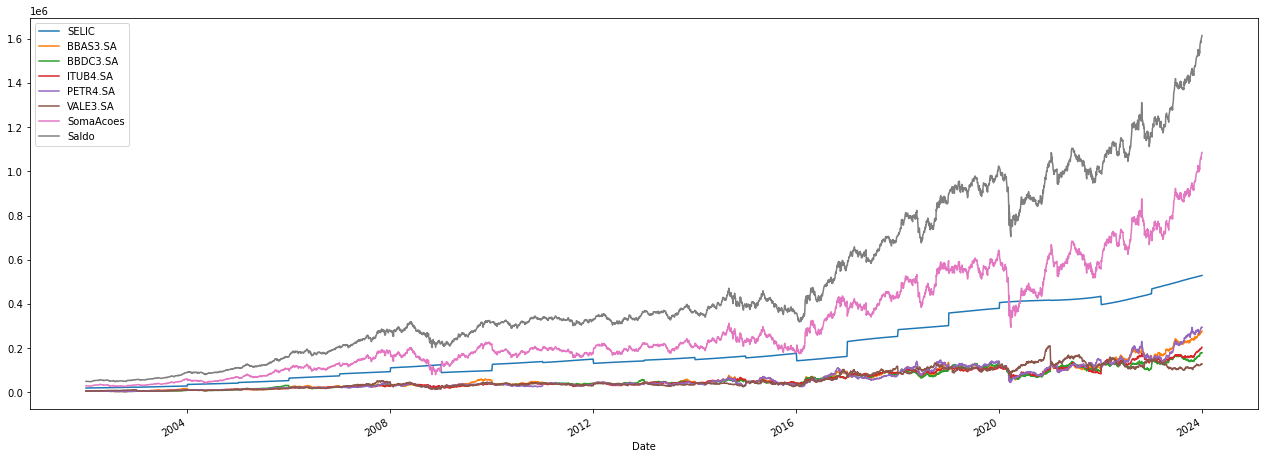

In [11]:
carteira_total.plot(figsize=(22,8))

In [12]:
ibov_normalizado = (ibov / ibov.iloc[0])*50000
ibov_normalizado

Date
2002-01-02     50000.000000
2002-01-03     51416.522491
2002-01-04     51658.016148
2002-01-07     51827.422145
2002-01-08     51066.897347
                  ...      
2023-12-21    476434.544406
2023-12-22    478492.647059
2023-12-26    481304.065744
2023-12-27    483686.562860
2023-12-28    483654.123414
Name: Adj Close, Length: 5447, dtype: float64

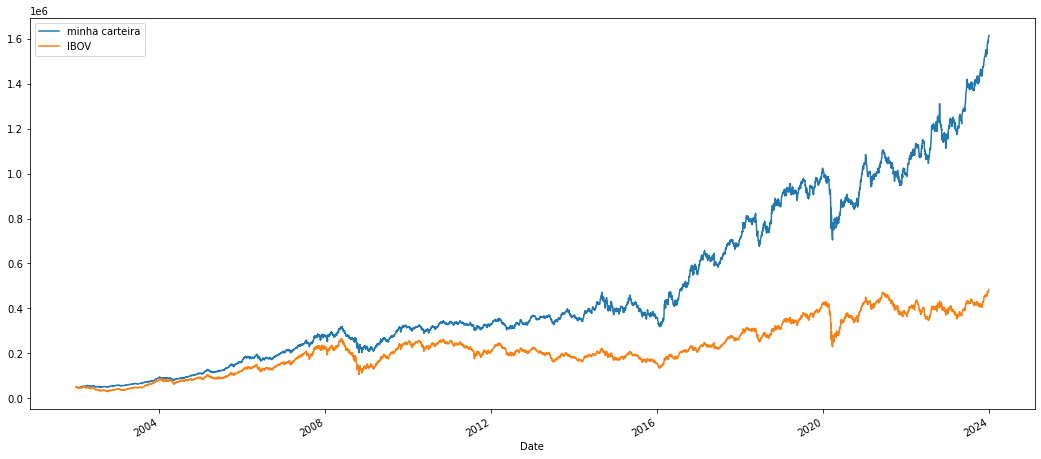

In [13]:
ibov_normalizado = (ibov / ibov.iloc[0])*50000
ibov_normalizado
carteira_total["Saldo"].plot(figsize=(18,8), label='minha carteira')
ibov_normalizado.plot(label="IBOV")
plt.legend()

In [14]:
ultimo_dado_por_ano = carteira_total.groupby(carteira_total.index.year).last()
print(ultimo_dado_por_ano)

              SELIC       BBAS3.SA       BBDC3.SA       ITUB4.SA  \
Date                                                               
2002   23954.610540    5552.407777    5824.871518    5846.926723   
2003   29038.521660   17190.277987    9258.226524   11746.677752   
2004   42213.588287   14682.513070   12250.164708   15073.689606   
2005   53535.725685   17715.804621   31582.627049   18833.034331   
2006   74779.778516   30395.329925   26289.747275   26758.250846   
2007   93907.909666   33330.807707   30541.658327   27232.320345   
2008  125197.759983   18026.784002   21420.333420   24876.342207   
2009   98648.300571   55112.754870   38114.934558   39549.703824   
2010  139760.458510   46988.651827   40644.623953   39696.090294   
2011  150753.170478   35912.652107   41865.445755   36626.708492   
2012  142416.380486   47054.887183   56560.969079   40807.986196   
2013  157896.340268   49046.297122   43963.757389   46395.423232   
2014  164464.946230   53473.636138   52573.44363